In [1]:
import matplotlib.pyplot as plt
import os
import json
import numpy as np

In [2]:
# Select the dataset you need
dataset_name = "kvasir"

# Replace by source dir location
source_dir = f'/home/rob/Documents/3_projects/mac/_analysis/{dataset_name}'

In [3]:
def show_CI_graph(dataset_name: str, source_dir: str, binary: bool = True) -> None:
    # Load JSON files
    json_files = [f for f in os.listdir(source_dir) if f.endswith('.json')]
    
    # Dictionary to store the data
    data = {}
    
    # Load each JSON file and store the data
    for json_file in json_files:
        with open(os.path.join(source_dir, json_file), 'r') as f:
            data[json_file] = json.load(f)
    
    # Extract the mean values and confidence intervals for each metric from each model
    if binary:
        metrics = ['dice_score', 'IoU_score', 'precision_metric', 'recall_metric', 'accuracy_metric']
    else:
        metrics = ['IoU_score', 'precision_metric', 'recall_metric', 'accuracy_metric']
    model_names = list(data.keys())
    mean_values = {metric: [] for metric in metrics}
    ci_values = {metric: [] for metric in metrics}
    legend_labels = []
    
    for model in model_names:
        # Clean up the model name and append the number of parameters
        cleaned_model_name = model.replace('_data.json', '')
        num_params = data[model]['num_params']
        legend_labels.append(f'{cleaned_model_name} (Params: {num_params:,})')
        
        for metric in metrics:
            mean = data[model][metric]['mean'] * 100  # Convert to percentage
            ci_lower = data[model][metric]['95% CI'][0] * 100
            ci_upper = data[model][metric]['95% CI'][1] * 100
            mean_values[metric].append(mean)
            ci_values[metric].append([ci_lower, ci_upper])
    
    # Plotting the data using box plots
    fig, ax = plt.subplots(figsize=(14, 6))
    
    positions = []
    for i, metric in enumerate(metrics):
        # Data for boxplot: mean is marked, CI as the box, min/max as the whiskers
        box_data = [ci_values[metric][j] for j in range(len(model_names))]
        pos = np.arange(len(model_names)) + i * (len(model_names) + 1)
        positions.extend(pos)
        
        # Plot boxplot for each metric
        bp = ax.boxplot(box_data, positions=pos, widths=0.6, patch_artist=True, 
                        showmeans=True, meanline=False, 
                        meanprops=dict(marker='o', markerfacecolor='red', markeredgecolor='black', markersize=10))
        
        # Add color to boxes and create legend handles
        for patch, color in zip(bp['boxes'], plt.cm.tab20.colors[i*len(model_names):(i+1)*len(model_names)]):
            patch.set_facecolor(color)
    
        for j in range(len(model_names)):
            ax.text(pos[j], mean_values[metric][j], f'{mean_values[metric][j]:.2f}%', 
                    ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # Customizing the plot
    ax.set_xlabel('Metrics', fontsize=10)
    ax.set_ylabel('Values (%)', fontsize=10)
    ax.set_title(f'Performance Comparison with 95% Confidence Intervals - {dataset_name}', fontsize=14)
    ax.set_xticks(np.arange(len(metrics)) * (len(model_names) + 1) + (len(model_names) - 1) / 2)
    ax.set_xticklabels(metrics, fontsize=10)
    
    # Rotate the tick labels for better readability
    plt.xticks(rotation=45)
    
    # Create a legend below the x-axis
    legend_handles = [plt.Line2D([0], [0], color=plt.cm.tab20.colors[i], lw=4) for i in range(len(model_names))]
    ax.legend(legend_handles, legend_labels, loc='upper center', bbox_to_anchor=(0.5, -0.25), ncol=len(model_names), fontsize=8, title="Models")
    
    # Show plot
    plt.tight_layout()
    
    # Save as pdf
    output_path = os.path.join(source_dir, f'{dataset_name}_performance_comparison_with_CI.pdf')
    plt.savefig(output_path, format='pdf')
    
    plt.show()


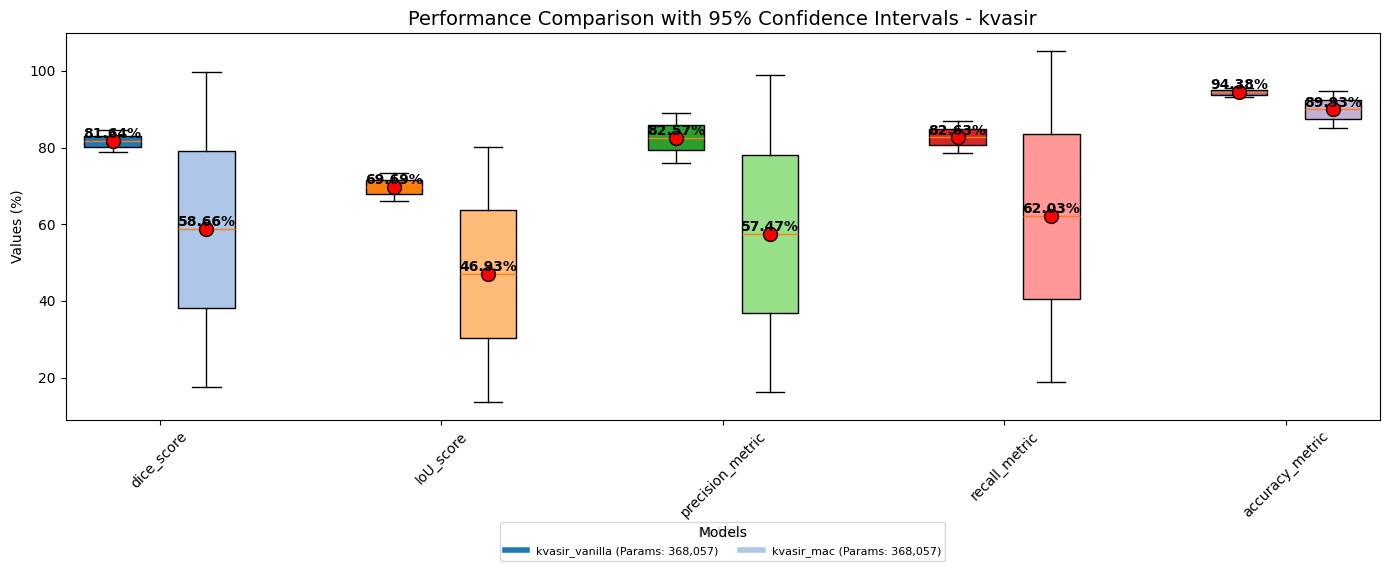

In [4]:
show_CI_graph(dataset_name, source_dir)